In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)


class DataSet(torch.utils.data.Dataset):
    def __init__(self, train=True):
        dataset = datasets.MNIST(root='../data', train=train, download=True)
        self.data = dataset.data
        self.targ = dataset.targets

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targ[idx]

train_dataset = DataSet(train=True)
test_dataset = DataSet(train=False)

device : cpu
torch.version : 1.9.0+cu102



Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class RBM(nn.Module):
    def __init__(self, num_x, num_h):
        super().__init__()
        self.num_x, self.num_h = num_x, num_h
        self.w = nn.Parameter(torch.Tensor(num_h, num_x))
        self.b_x = nn.Parameter(torch.Tensor(num_x))
        self.b_h = nn.Parameter(torch.Tensor(num_h))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.w.data, 0., np.sqrt(2./(self.num_h + self.num_x)))
        nn.init.zeros_(self.b_x.data)
        nn.init.zeros_(self.b_h.data)

    def p_h_given_x(self, x):
        logit = torch.mm(x, self.w.t()) + self.b_h
        return logit.sigmoid()

    def p_x_given_h(self, h):
        logit = torch.mm(h, self.w) + self.b_x
        return logit.sigmoid()

    def log_unnorm_p_x(self, x):
        a = ((torch.mm(x, self.w.t()) + self.b_h).exp() + 1.).log().sum(dim=-1)
        b = (self.b_x * x).sum(dim=-1)
        return a + b

    def log_unnorm_p_h(self, h):
        a = ((torch.mm(h, self.w) + self.b_x).exp() + 1.).log().sum(dim=-1)
        b = (self.b_h * h).sum(dim=-1)
        return a + b
    
    @torch.no_grad()
    def gibbs_sampling(self, given, num_step, given_type='x'):
        assert given_type in ['x', 'h']
        x = given if given_type == 'x' else torch.bernoulli(self.p_x_given_h(given))
        for _ in range(num_step):
            h = torch.bernoulli(self.p_h_given_x(x))
            x = torch.bernoulli(self.p_x_given_h(h))
        return x



In [295]:
batch_size = 64
lr = 1e-4
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
rbm = RBM(784, 500)
optimizer = optim.Adam(rbm.parameters(), lr=lr)

In [296]:
for epoch in range(10):
    avg_loss = np.array([0., 0.])

    for x, y in loader:
        x_pos = x.float().to(device).flatten(1, -1) / 255
        x_pos = torch.ones_like(x_pos) * (x_pos > 0.5)
        
        


        x_neg = [x_pos]
        for k in range(2):
            x_neg.append(rbm.gibbs_sampling(x_neg[-1], 10))

        x_neg = torch.cat(x_neg, dim=0)
        
        optimizer.zero_grad()
        lup_neg = rbm.log_unnorm_p_x(x_neg).mean()
        lup_pos = rbm.log_unnorm_p_x(x_pos).mean()

        loss = lup_neg - lup_pos
        loss.backward()
        optimizer.step()
        avg_loss += [lup_pos.item(), lup_neg.item()]
    avg_loss /= len(loader)
    print(avg_loss)


[314.40789984 269.41359493]
[313.15404453 294.98425088]
[320.88382652 307.0033767 ]
[327.69929193 314.78426127]
[333.27717712 320.8326303 ]
[338.35765002 326.41386418]
[342.696336  331.1713945]
[346.23288866 335.06269893]
[349.81163342 338.747625  ]
[353.65304246 342.7415378 ]


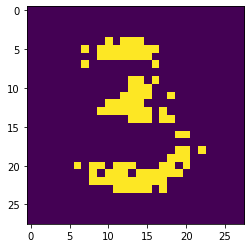

In [305]:
x_neg = rbm.gibbs_sampling(x_pos, 50)
plt.imshow(x_neg[5].view(28, 28))
plt.show()